In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 15 14:29:44 2019

@author: stefgarasto
"""


import os
import pickle
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from operator import itemgetter
import time
from fuzzywuzzy import process
import itertools

In [2]:
# set up plot style
print(plt.style.available)
plt.style.use(['seaborn-darkgrid','seaborn-poster'])

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [3]:
from utils_nos import nesta_colours, nesta_colours_combos
print(nesta_colours, nesta_colours_combos)

[[1, 0.7215686274509804, 0.09803921568627451], [1, 0, 0.2549019607843137], [0, 0, 0], [1, 0.35294117647058826, 0], [0.6078431372549019, 0, 0.7647058823529411], [0.6470588235294118, 0.5803921568627451, 0.5098039215686274], [0.6274509803921569, 0.5686274509803921, 0.1568627450980392], [0.7686274509803922, 0.6901960784313725, 0], [0.9647058823529412, 0.49411764705882355, 0], [0.7843137254901961, 0.1568627450980392, 0.5725490196078431], [0.23529411764705882, 0.07058823529411765, 0.3215686274509804]] [[0, 1, 2, 3, 4, 5], [0, 6, 7], [1, 3, 8], [4, 9, 10], [8, 5], [1, 11]]


In [4]:
output_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/'
lookup_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/extracted/'

In [5]:
SAVEFIG = False

In [6]:
qualifier = 'final_no_dropped'


In [7]:
# flatten lists of lists
def flatten_lol(t):
    return list(itertools.chain.from_iterable(t))
flatten_lol([[1,2],[3],[4,5,6]])

[1, 2, 3, 4, 5, 6]

In [8]:
def print_elapsed(t0_local, task = 'current task'):
    print('Done with {}. Elapsed time: {:4f}'.format(task,time.time()-t0_local))

In [9]:
####### Definitions
def unique(list1):

    # intilize a null list
    unique_list = []
    repeated_elems = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
        else:
            repeated_elems.append(x)
    return unique_list, repeated_elems

In [10]:
def add_text_to_hist(values, xvalues = None, orient = 'vertical'):
    addval = .5 + np.floor(2*np.log(max(values)))
    addx = -.2 if orient=='horizontal' else 0
    for ix,i in enumerate(values):
        if i>0:
            if not xvalues:
                x = ix - .2
            else:
                x = xvalues[ix] -.2
            if orient == 'vertical':
                plt.text(i+addval, x, '{}'.format(i), fontsize = 14)
            else:
                plt.text(x, i+addval,'{}'.format(i), fontsize = 14)

# Functions to clean the data
They have been developed after manual exploration of the data

In [11]:
# make everything lowercase
def make_lowercase(x):
    if isinstance(x,str):
        return x.lower().replace('â€™','').replace('â','')
    else:
        return x

In [12]:
def meta_suites_corrections(x):
    if isinstance(x, str):
        x = x.lower()
        x = x.strip().replace('\n','').replace('–','-').replace('&','and').replace('-',' ').replace('/',' ')
        x = x.replace('(','').replace(')','').replace(':','').replace('\'','')
        x = x.replace('＆','and ')
        x = ' '.join(x.split('\n'))
        #x = ' '.join(x.split())
        # eliminate multiple spaces
        x = re.sub(r'\s+', ' ', x)
        # remove leading and trailing spaces
        x = x.strip()
        x = x.replace('trades','trade').replace('professionals','professional')
        x = x.replace('jusitce','justice')
        x = x.replace('turbines','turbine').replace('para professional','paraprofessional')
        x = x.replace('orderivatives','or derivatives').replace('productions','production')
        x = x.replace('securities derivatives', 'securities or derivatives').replace('persons','person')
        x = x.replace('orderivatives','or derivatives')
        x = x.replace('minerals','mineral')
        x = x.replace('managemnet','management')
        x = x.replace('monitorin operations','monitoring operations')
        x = x.replace('digitial','digital')
        x = x.replace('propr','props')
        x = x.replace('pre cast','precast')
        x = x.replace('fenestration i','fenestration, i')
        x = x.replace('managmement','management')
        x = x.replace('auxillary','auxiliary')
        x = x.replace('installations','installation')
        x = x.replace('vererinary','veterinary')
        x = x.replace('managmement','management')
        x = x.replace('wood machining','woodmachining')
        x = x.replace('mangement','management')
        x = x.replace('small holders','smallholders')
        x = x.replace('digitial','digital')
        x = x.replace('performanceandnbsp','performance')
        x = x.replace('administration nos','administration')
        x = x.replace('asphalting', 'asphalt')
        x = x.replace('installing domestic fascia, soffit,', 'installation of domestic fascias, soffits')
        x=x.replace('skills for security essential employability nos','skills for security essential employability')
        x = x.replace('fenestration and installation surveying','fenestration, installation and surveying')
        # ('nail services', 100), ('mail services', 92)
        #x = x.replace('medicinal','medical')
        #x = correction(x)
    else:
        print(x)
    return x

In [13]:
#TODO: clean up rather than delete suites, also remove years from suites but keep the "suite number"
# things to do to clean up suites names:
'''
1. remove brackets
2. traderepair --> trade repair
3. & to and
4. check why sound and sound are split
5. check wood constructions
6. eliminate years
7. plastering (construction), roofing occupations (construction) --> split. 
7a. Generally, split by comma too (not sure, actually)
8. offshore s1971 elected safety representatives is the only one with a number in the middle
8a. joking, there is also h2s & other hazardous gases; 1132 marketing and sales managers; 
9. remove - and similar (like hospitality â€“ generics)
10. be careful with laboratory and associated technical activities suite 32010 (and 42019 and 22010)
11. be careful of it users 6.2 too
12. constructionindustry
13. operationscoating
24. remove leading and end spaces
'''
def clean_suites(x):
    if isinstance(x, str):
        x = x.replace('(',' ')
        x = x.replace(')',' ')
        if ('22010' in x) or ('32010' in x) or ('42010' in x):
            x = x[0:-4]
        x = x.replace('&','and')
        # remove year
        #if 's1971' not in x:
        #    x = re.sub('\d{4}',' ', x)
        #    if 'h2s' not in x:
        #        # add a semicolon after a number so that you can split by it later
        #        x = re.sub('(\d)', r'\1;', x)
        x = x.replace('&', 'and ')
        x = x.replace('â€“', '')
        #x = x.replace('– ',' ')
        x = x.replace('–',' ')
        #x = x.replace('- ',' ')
        x = x.replace('-',' ')
        x = x.replace('/' ,' ')
        x = x.replace('.',' ')
        x = x.replace('\'','')
        # remove new line symbols
        x = ' '.join(x.split('\n'))
        if 'editing, grip, design for the moving image,' in x:
            x = ';'.join(x.split(','))
        if 'operations construction, refractory installation' in x:
            x = ';'.join(x.split(','))
        # eliminate multiple spaces
        x = re.sub(r'\s+', ' ', x)
        # remove leading and trailing spaces
        x = x.strip()
        #TODO: with few exception if I find a group of max 3 digits not at 
        #the end and followed by a space or a letter, that's a point I should split
        if ('wood occupation' in x) and ('adv' not in x):
            x = 'wood occupations construction'
        x = x.replace('traderepair', 'trade repair')
        x = x.replace('constructionindustry','construction industry')
        x = x.replace('operationscoating','operations coating')
        x = x.replace('ofelectrical','of electrical')
        x = x.replace('mineralsprocessing','minerals processing')
        x = x.replace('differentcountries','different countries')
        x = x.replace('combinedworking','combined working')
        x = x.replace('localgovernment', 'local government')
        x = x.replace('eventsecurity','event security')
        x = x.replace('cropproduction','crop production')
        x = x.replace('customerservices','customer services')
        x = x.replace('occupationsresidential','occupations residential')
        x = x.replace('systemsmaintenance','systems maintenance')
        x = x.replace('andrefurbishment','and refurbishment')
        x = x.replace('materialsprocessing','materials processing')
        x = x.replace('thebuilding','the building')
        x = x.replace('managerfire','manager fire')
        x = x.replace('formanagement','for management')
        x = x.replace('alliedoperation','allied operation')
        x = x.replace('safetyrequirementsfabrication','safety requirements fabrication')
        x = x.replace('operationsdrilling', 'operations drilling')
        x = x.replace('operationsbulk', 'operations bulk')
        x = x.replace('andmanagement', 'and management')
        x = x.replace('artsmanagement','arts management')
        x = x.replace('pensions','pension')
        x = x.replace('extrusion furniture', 'extrusion and furniture')
        x = x.replace('ofconstruction','of construction')
        x = x.replace('2008aeronautical', '2008 aeronautical')
        x = x.replace('2rail', '2 rail')
        x = x.replace('2006engineering', '2006 engineering')
        x = x.replace('1132 marketing','marketing')
        x = x.replace('nail services 2009 2009', 'nail services 2009')
        x = x.replace('roadbuilding','road building')
        x = x.replace('seniorroles','senior roles')
        x = x.replace('511con po1561', '')
        x = x.replace('nailservices','nail services')
        x = x.replace('servicesnos','services nos')
        x = x.replace('sitelogistics','site logistics')
        x = x.replace('securityoperations','security operations')
        x = x.replace('andtendering','and tendering')
        x = x.replace('andnbsp','')
        x = x.replace('airconditioning', 'air conditioning')
        x = x.replace('therapiharddwch','therapi harddwch')
        # eliminate multiple spaces
        x = re.sub(r'\s+', ' ', x)
        # remove leading and trailing spaces
        x = x.strip()
        if x in ['',' ','skills cfa', ' skills for security essential employability',' skills for security']:
            x = 'empty'
    return x



In [14]:
### Perform some more manual cleanup
# this is for the document Status
def lower_or_empty_status(x):
    if isinstance(x,str):
        y= x.lower()
    else:
        y= 'empty'
    if y in ['orginal', 'origianl','orignal','original ??????????','original3']:
        y = 'original'
    elif y in ['import', 'imported from ento', 'amended form imported ento unit']:
        y = 'imported'
    elif y == 'tailored from ento':
        y = 'tailored'
    elif y == 'may 2016':
        y = 'empty'
    elif y == 'building information modelling':
        y== 'empty'
    # remove those that are "out of range"
    if y not in ['original', 'tailored','imported']:
        y = 'empty'
    y = y.replace('&','and')
    return y

def lower_or_empty_validity(x):
    if isinstance(x,str):
        y= x.lower()
    else:
        y= 'empty'
    # also, fix some common mis-spellings:
    if y in ['currentl','curent']:
        y = 'current'
    elif y == 'may 2016':
        y = 'empty'
    elif y == 'building information modelling':
        y== 'empty'
    # remove those that are "out of range"
    if y not in ['current','legacy','archive']:
        y = 'empty'
    y = y.replace('&','and')
    return y

# for the Developed_by columns make all lower case and drop some
# obviously wrong rows
def lower_or_empty(x):
    if isinstance(x,str):
        y= x.lower()
    else:
        y= 'empty'
    # also, fix some common mis-spellings:
    if y == 'may 2016':
        y = 'empty'
    elif y == 'building information modelling':
        y = 'empty'
    elif 'manufacturers instructions6method' in y:
        y = 'empty'
    elif y in ['proskills uk', 'manual, electronic systems, process warning enunciatorsprocess documents and logs, checklistssafety notice boards, safety data sheets, warning signsproskills',
              'proskillls']:
        y = 'proskills'
    elif y in ['summitskillsversionnumber1', 'summit skills']:
        y = 'summitskills'
    elif y == 'manufacturersâ€™ instructions6method statements7product worksheetsengineering construction industry training board':
        y = 'empty'
    elif y in ['how signals can enter, route through and exit mixing and recordinghow to identify common signal routing stages of mixing and recordingthe relationship between the stereo master section and a singlechannel -describetypes of professional mixing and recording consolesthe features of different professional recording consolesthe types of console different music and sound sectors requirethe main sector manufacturers of equipment for studio recording andmixing studios/programming consolesthe main sector manufacturers of equipment forbroadcast/tv/av/radio consolesthe main sector manufacturers of equipment for live mobile recording,theatre/performance and live sound/pa equipment for venuescreative & cultural skills',
              'creative and cultrual skills']:
        y = 'creative and cultural skills'
    elif y in ['skiillsactive','skills active', 
              'skillsactiveevelop your tactical skills to achieve excellence in your sport']:
        y = 'skillsactive'
    elif y in ['cfa', 'cfa business skill @ work', 'cfa business @ work',
              'these business enterprise units may be relevant when you are setting up ordeveloping a business:ys1 explore your own business motivesys2 check your ability to run your businessys3 improve your business skillsee3 make deals to take your business forwardcfa business skills @ workz0g.docx']:
        y = 'cfa business skills @ work'
    elif y in ['mpqcrovide leadership in the mine',
              'subsequent legislation that supersedes it, as appropriate to the workactivitympqclast to specification',
              'resources: tools, equipment, utilities or services, consumablesmpqc',
              'mpqceparate and dispose of wastes and by-products from mining and relatedprocessing activities',
              'to the workplace, work activity and the associated environmental impactsmpqconitor and maintain environmental conditions in your area of responsibility',
              'mpqcrocess materials to specification','[mpqc']:
        y = 'mpqc'
    elif y in ['6.46.5semtacomputer-based recordelectronic mail',
               'complete the relevant paperwork, to include one from the following andpass it to the appropriate people:7.1 build records7.2 computer records7.3 job cards7.4 aircraft service/flight log other specific recording methodsemta']:
        y = 'semta'
    elif y == 'people1st':
        y = 'people 1st'
    elif y in ['security threatse-skills uk', 'e-skills',
               'k12.5 verifying the accuracy, currency, completeness and relevance ofinformation created, collected, used and documented during datadesign activitiese-skills uk',
              'e-skills uk ssc', 'e-skills uk sector skills council', 'skills uk']:
        y = 'e-skills uk'
    elif y == '[habia':
        y = 'habia'
    elif y == 'skills cfa in partnership with sfedi':
        y = 'skills cfa'
    elif y == 'skill for justice':
        y = 'skills for justice'
    elif y == 'assetskills':
        y = 'asset skills'
    elif y in ['the institute of the motor industry (imi)', 'imi ltd']:
        y = 'imi'
    elif y == 'enery and utility skills':
        y = 'energy and utility skills'
    elif y == 'improve ltd':
        y = 'improve'
    elif y in ['skills thirds sector', 'skills – third sector']:
        y = 'skills third sector'
    elif y in ['lifelong and skills improvement service', 'lifelong learning and skills improvement service',
               'learning and skills improvement skills', 'learning and skills development service']: 
        y = 'learning and skills improvement service'
    if y in ['e-skills','e-skills uk']:
        y = 'tech partnership'
    elif y == 'improve':
        y = 'nsafd'
    # finally, change & to and
    y = y.replace('&','and')
    y = y.strip()
    return y


In [15]:
# add the year in which it was approved and the indicative review year
# first you need to look for the month and the year
def extract_monthyear(x):
    reg_exp = 'jan|january|february|march|april|may|june|july|august|september|october|november|december'
    p = re.compile(reg_exp)
    # search for the regular expression and only get the first occurrence
    # we will be assuming that the year is right after the month
    if isinstance(x,str):
        # first check if they are all digits:
        if all([d.isdigit() for d in x]):
            return x
        if p.search(x.lower()):
            start, end = p.search(x.lower()).span()
            # get intermediate string:
            tmp_s = x[start:end+10]
            # find first and last digit in the intermediate string
            digits = [ii for ii,d in enumerate(tmp_s) if d.isdigit()]
            if len(digits):
                year = tmp_s[digits[0]:digits[-1]+1]
            else:
                return 'july 2130'
            # check if there is another string:
            x2 = x[end:]
            if p.search(x2.lower()):
                start2, end2 = p.search(x2.lower()).span()
                # get intermediate string:
                tmp_s2 = x2[start2:end2+10]
                # find first and last digit in the intermediate string
                digits2 = [ii for ii,d in enumerate(tmp_s2) if d.isdigit()]
                year2 = tmp_s2[digits2[0]:digits2[-1]+1]
                if int(year2)>int(year):
                    return x2[start2:end2].lower() + ' ' + year2
                else:
                    x[start:end].lower() + ' ' + year
            else:
                return x[start:end].lower() + ' ' + year
        else:
            return 'july 2130'
    else:
        return 'july 2130'

# Load metadata and light cleaning

In [16]:
#### get the file where the metadata is stored
metadata_dir = '/Users/stefgarasto/Google Drive/Documents/data/NOS_meta_data/'
metadata_file = 'PublishedNos Details.xlsx'
metadata_file_old = 'PublishedNos-old Details.xlsx'


In [17]:
# load old nos
metadata_old = pd.read_excel(os.path.join(metadata_dir, metadata_file_old))
metadata_old.head(n=2)

,Developed By,NOS Title,Suite,SuiteMetadata,Occupations,OccupationsMetadata,Name,Validity,Indicative Review Date,NOS Document Status,URN,SOC Code,NOSCategory,Keywords,Original URN,Created,Modified,Item Type,Path
0,Lantra,Offer Reiki to animals,Veterinary paraprofessional activities,1218;#Veterinary paraprofessional activities,Animal Reiki Practitioner,2850;#Animal Reiki Practitioner,LANACT3.pdf,Current,2023-04-30,Original,LANACT3,NaN,NaN,Reiki; animal; therapy; natural; holistic; com...,LANACT3,2018-07-19 16:21:04,2018-08-07 16:40:01,Item,PublishedNos-old
1,Lantra,Develop and agree plans for complementary and ...,Veterinary paraprofessional activities,1218;#Veterinary paraprofessional activities,Animal complementary and natural/holistic heal...,1287;#Animal complementary and natural/holisti...,LANACT2.pdf,Current,2023-04-30,Original,LANACT2,NaN,NaN,animals; therapy; complementary; natural; holi...,LANACT2,2018-07-19 16:21:02,2018-08-07 11:27:23,Item,PublishedNos-old


In [18]:
# load new nos
metadata = pd.read_excel(os.path.join(metadata_dir, metadata_file))
metadata.head(n=2)


,Developed By,NOS Title,Suite,SuiteMetadata,Occupations,OccupationsMetadata,Name,Validity,Indicative Review Date,NOS Document Status,URN,SOC Code,NOSCategory,Keywords,Original URN,Created,Modified,Item Type,Path
0,Creative Skillset,Edit audio and video material for journalistic...,Journalism,1571;#Journalism,"Arts, Media and Publishing","29;#Arts, Media and Publishing",Edit-audio-and-video-material-for-journalistic...,Current,2022-03-31,Original,SKSJ29,2471,Job Specific,Edit; Audio; Video; Journalism; Material,SKSJ29,2019-04-04 18:17:52,2019-04-04 18:17:52,Item,PublishedNos
1,Creative Skillset,Design and produce page layout,Journalism,1571;#Journalism,Media and communication; Media Associate Profe...,543;#Media and communication;#570;#Media Assoc...,Design-and-produce-page-layout-SKSJ28.pdf,Current,2022-03-31,Original,SKSJ28,2471,Job Specific,"page layout, design, journalism",SKSJ28,2019-04-04 18:17:51,2019-04-04 18:17:51,Item,PublishedNos


In [19]:
# load new nos
metadata2 = pd.read_excel(os.path.join(metadata_dir, metadata_file))
print(metadata2['Suite'].isnull().sum())
metadata_old2 = pd.read_excel(os.path.join(metadata_dir, metadata_file_old))
print(metadata_old2['Suite'].isnull().sum())
metadata2 = None
metadata_old2 = None

16
2


In [20]:
# concatenate all metadata (old and new)
metadata_old.set_index = range(len(metadata),len(metadata)+len(metadata_old))
metadata = pd.concat((metadata,metadata_old),ignore_index = True,sort=False)
metadata.columns


Index(['Developed By', 'NOS Title', 'Suite', 'SuiteMetadata', 'Occupations',
       'OccupationsMetadata', 'Name', 'Validity', 'Indicative Review Date',
       'NOS Document Status', 'URN', 'SOC Code', 'NOSCategory', 'Keywords',
       'Original URN', 'Created', 'Modified', 'Item Type', 'Path'],
      dtype='object')

## Light cleaning of NOS meta-data
 - eliminate rows with no information
 - remove duplicates
 - replace "jobspecific" with "job specific"
 - make lowercase

In [21]:
# make it all lowercase
metadata = metadata.applymap(make_lowercase)


In [22]:
# show the rows with no info
metadata[metadata['NOS Title'].isnull()].head(n=2)


,Developed By,NOS Title,Suite,SuiteMetadata,Occupations,OccupationsMetadata,Name,Validity,Indicative Review Date,NOS Document Status,URN,SOC Code,NOSCategory,Keywords,Original URN,Created,Modified,Item Type,Path
185,NaN,NaN,NaN,NaN,NaN,NaN,skass24.pdf,NaN,NaT,NaN,NaN,NaN,core,NaN,NaN,2019-04-01 13:43:57,2019-04-01 13:43:57,item,publishednos
186,NaN,NaN,NaN,NaN,NaN,NaN,skass23.pdf,NaN,NaT,NaN,NaN,NaN,core,NaN,NaN,2019-04-01 13:43:56,2019-04-01 13:43:56,item,publishednos


In [23]:
# 1. eliminate rows with no information (see printout above)
metadata = metadata[~metadata['NOS Title'].isnull()]

# 2. known bug: some NOS are repeated (same pdf name) and only one of them actually contains relevant info
metadata['Name'] = metadata['Name'].map(lambda x: x.strip())
# find where the duplicates are (everything with value counts > 1, so find the first non-duplicate one)
ix = np.where(metadata['Name'].value_counts().values==1)[0][0]
repeated_meta_names = metadata['Name'].value_counts()[0:ix].index.values
repeated_meta_counts = metadata['Name'].value_counts()[0:ix].values

print(len(repeated_meta_names))
for t in repeated_meta_names[:3]:
    print(metadata[metadata['Name']==t][['SOC Code','Path','NOSCategory']])
    print('\n')

# if necessary, print the duplicated rows
PRINTONFILE = False
if PRINTONFILE:
    metadata[metadata['Name'].map(lambda x: x in repeated_meta_names)].to_csv(os.path.join(output_dir,
                                                                    'repeated_metadata_pdfnames.csv'))


41
     SOC Code              Path  NOSCategory
1169      NaN      publishednos          NaN
1633     5314  publishednos-old  jobspecific


     SOC Code              Path  NOSCategory
673       NaN      publishednos          NaN
1651     5314  publishednos-old  jobspecific


     SOC Code              Path NOSCategory
1219      NaN      publishednos         NaN
1226     5119  publishednos-old         NaN




In [24]:
# remove duplicate file names (keep the last one because it has the SOC code, at least here)
metadata.drop_duplicates(subset = 'Name', inplace = True, keep = 'last')
metadata = metadata.reset_index(drop = 'True')

jobspecific     9660
core            2210
generic         1843
job specific     631
Name: NOSCategory, dtype: int64


/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


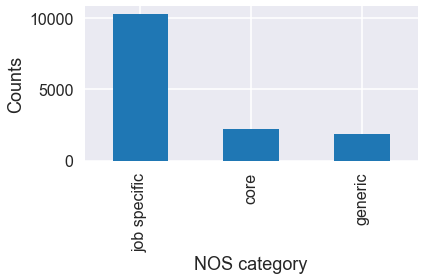

In [25]:
# replace "jobspecific" with "job specific" and plot counts
print(metadata['NOSCategory'].value_counts())
metadata['NOSCategory'][metadata['NOSCategory'] == 'jobspecific'] = 'job specific'
f = plt.figure(figsize = (6,4))
metadata['NOSCategory'].value_counts().plot(kind='bar')
plt.ylabel('Counts',fontsize = 18)
plt.xlabel('NOS category',fontsize = 18)
plt.tight_layout()
#if SAVEFIG:
#    plt.savefig(os.path.join(output_dir,'nos_categories_{}.png'.format(qualifier)))

In [26]:
# print out how many repeated/missing URNs there are
print(len(metadata), len(metadata['URN'].value_counts()))
ix = np.where(metadata['URN'].value_counts()==1)[0][0]
repeated_urns = metadata['URN'].value_counts()[0:ix].index.values
print('Number of repeated URNs is: ',len(repeated_urns))
print('Number of NAN URNs is: ',metadata['URN'].isnull().sum())
# TODO: print all repeated URNs from ActiveIS data

22036 20798
Number of repeated URNs is:  1234
Number of NAN URNs is:  0


In [27]:
# some suites are lists separated by ";": extract all unique suites
all_ground_suites = []
for row in metadata.index:
    if isinstance(metadata['Suite'].loc[row],str):
        all_ground_suites += metadata['Suite'].loc[row].split(";")
        if 'ma' in metadata['Suite'].loc[row].split(";"):
            # print the NOS with the weird suite
            print(row,metadata['Name'].loc[row])
t0 = time.time()

print('Number of unique suites before cleaning: {}'.format(len(list(set(all_ground_suites)))))

'''
# clean the suites and check how many there are
all_ground_suites_clean = [meta_suites_corrections(t) for t in all_ground_suites]
print_elapsed(t0,'correcting ground truth suites')

all_ground_suites_clean = list(set(all_ground_suites_clean))
if all_ground_suites_clean[0]=='':
    all_ground_suites_clean = all_ground_suites_clean[1:]
print('Number of unique suites from Active IS metadata: ',len(all_ground_suites_clean))
'''

6922 skaes2.pdf
Number of unique suites before cleaning: 1457


"\n# clean the suites and check how many there are\nall_ground_suites_clean = [meta_suites_corrections(t) for t in all_ground_suites]\nprint_elapsed(t0,'correcting ground truth suites')\n\nall_ground_suites_clean = list(set(all_ground_suites_clean))\nif all_ground_suites_clean[0]=='':\n    all_ground_suites_clean = all_ground_suites_clean[1:]\nprint('Number of unique suites from Active IS metadata: ',len(all_ground_suites_clean))\n"

In [28]:
# Here I kind of want to show the process behind the data cleaning.
# Note that so far, I have not actually cleaned the suite names
# first, get unique suites
all_ground_suites = list(set(all_ground_suites))
print('Number of unique suites before any cleaning: {}'.format(len(all_ground_suites)))
all_ground_suites = [t.strip() for t in all_ground_suites if len(t)]
all_ground_suites = list(set(all_ground_suites))
if all_ground_suites[0] == '':
    all_ground_suites = all_ground_suites[1:]

print('Number of unique suites after only removing spaces: {}'.format(len(all_ground_suites)))
suites_checked = []
METASUITEMATCH = False
if METASUITEMATCH:
    # for each of them print those with fuzzy matching more than tot
    # do not do them twice, it just needs to be roughly consistent
    suites_matched = {}
    for ix in range(len(all_ground_suites)):
        if all_ground_suites[ix] not in suites_checked:
            out = process.extract(all_ground_suites[ix], all_ground_suites, limit=4)
            scores = [t[1] for t in out]
            max_ix = np.where(np.array(scores)>88)[0][-1]
            suites_matched[all_ground_suites[ix]] = {}
            for ix2 in range(1,max_ix+1):
                suites_matched[all_ground_suites[ix]]['{}'.format(ix2)] = out[ix2][0]
                suites_checked.append(out[ix2][0])
    pd.DataFrame.from_dict(suites_matched, orient= 'index').to_csv(os.path.join(output_dir,
                                                                    'potential_suites_matches_activeis_all.csv'))


Number of unique suites before any cleaning: 1457
Number of unique suites after only removing spaces: 1119


In [29]:
# clean up a bit some of the organisations names
def clean_dev_orgs_meta(x):
    x = x.replace('&','and')
    if x in ['e-skills','e-skills uk']:
        x = 'tech partnership'
    elif x == 'improve':
        x = 'nsafd'
    x = x.strip()
    return x
metadata['Developed By'] = metadata['Developed By'].map(clean_dev_orgs_meta)
    

In [30]:
print(len(list(metadata['Developed By'].value_counts().index)))
list(metadata['Developed By'].value_counts().index)

42


['semta',
 'skills for health',
 'nsafd',
 'people 1st',
 'skills for justice',
 'construction skills',
 'lantra',
 'cogent',
 'proskills',
 'skills cfa',
 'creative skillset',
 'creative and cultural skills',
 'energy and utility skills',
 'flsp',
 'asset skills',
 'skillsactive',
 'tech partnership',
 'skills for care and development',
 'imi',
 'lsis',
 'skills for logistics',
 'skills for security',
 'ecitb',
 'skillsmart retail',
 'summit skills',
 'opito',
 'mpqc',
 'skillseffect',
 'msa',
 'tda',
 'pss',
 'bse skills',
 'jets',
 'cdi',
 'instructus',
 'merchant navy training board',
 'base',
 "international jack up barge operators' association",
 'constructionskills',
 'msc',
 'ics',
 'x']

# Load and light clean data extracted from pdfs
 - replace missing values (or values that are not string) with either -1 (version number) or "empty"
 - mark those rows as empty
 - make lowercase
 - extract years

In [31]:
######## Load and concatenate all NOS

data_dir = '../../results/NOS/extracted'
figure_dir = '../../results/NOS/nlp_analysis'
which_files = ['extracted_standards_New NOS 1.pickle', 'extracted_standards_New NOS 2.pickle']
for ii in range(1,23):
    which_files.append('extracted_standards_Old NOS {}.pickle'.format(ii))
#which_file = 'extracted_standards_Old NOS 22.pickle'

repeated_refs = []
tot_count = 0
# load all the extracted NOS and concatenate them
for ii,which_file in enumerate(which_files):
    version = 'new_' #'v2_'
    print(version + which_file)
    with open(os.path.join(data_dir, version + which_file),'rb') as f:
        standard_info_partial, standard_ref_partial, failed, _ = pickle.load(f)
    tot_count += len(standard_ref_partial)
    # quick check that the list of keys in the standard dictionary is the
    # same as the URNs in the standard_ref list
    tmp = [k.replace('_v2','').replace('_v3','').replace('_v4','') for k in standard_info_partial.keys()]
    if not unique(standard_ref_partial)[0] == unique(tmp)[0]:
        print('Dictionary keys and standard refs do not correspond. Something is wrong.')
    if ii == 0:
        standard_info= standard_info_partial
        standard_ref = standard_ref_partial
    else:
        # check if there is any ref that is already in the full list
        ref_intersection= list(set(standard_ref_partial).intersection(set(standard_ref)))
        if len(ref_intersection):
            #keep track of the repeated ones and add _v followed by the next 
            # available number to their dict keys
            repeated_refs = repeated_refs + ref_intersection
            for ref in ref_intersection:
                new_version = 2
                while ref + '_v{}'.format(new_version) in list(standard_info_partial.keys()):
                    new_version+=1
                    #print(new_version)
                standard_info_partial[ref + '_v{}'.format(new_version)
                    ] = standard_info_partial.pop(ref)
        standard_info.update(standard_info_partial)
        standard_ref = standard_ref + standard_ref_partial


standard_info_partial = None
standard_ref_partial = None
print(len(standard_info),tot_count)

# NOTE: The total number of NOS is 22757


new_extracted_standards_New NOS 1.pickle


FileNotFoundError: [Errno 2] No such file or directory: '../../results/NOS/extracted/new_extracted_standards_New NOS 1.pickle'

In [ ]:
# check if it's fine to turn some of the fields into string
# Specifically, these fields should be strings: URN, Title, Developed_by, Date_approved
# Indicative review date, Validity, Status, Originating organisation, Suite
# If it's not possible or the field is empty, then mark it as empty
# OBS:I would keep the Original URN as a list, since it can contain multiple one
# Also, version number should be an integer
for idct, key_dct in enumerate(standard_info):
    dct = standard_info[key_dct]
    needed_sections = []
    for key in ['Developed_by','Date_approved', 'Indicative_review_date', 
                'Originating_organisation', 'Status','Suite', 'Validity','Version_number']:
        if key in dct.keys():
            if len(dct[key]):
                tmp = dct[key][0]
                for ii in range(1,len(dct[key])):
                    tmp += dct[key][ii]
                dct[key] = tmp
                if key=='Version_number':
                    # sometimes, the Version number contains spurious characters, not only digit
                    # so I need to dig out whether there is a digit in it and take it out
                    # yes: sometimes this can return the wrong value, because it will stop at the
                    # first digit it encounters
                    s = dct['Version_number']
                    re_result = re.search('\d{1,2}',s) #('\d+',s)
                    if re_result:
                        dct['Version_number'] = int(s[re_result.span()[0]:re_result.span()[1]])
                    else:
                        dct['Version_number'] = -1
            else:
                # in this case the field was an empty list, meaning the section was empty.
                if key=='Version_number':
                    dct['Version_number'] = -1
                else:
                    dct[key] = 'empty'
    

print('Done')


In [ ]:
#%% Turn the nested dictionary into a dataframe
nos_data = pd.DataFrame.from_dict(standard_info, orient = 'index')
print(nos_data.columns)
# mark all the rows with at least one column == 'empty' or == -1 as empty (see above as to why)
nos_data['empty'] = nos_data.apply(lambda x: (x=='empty') | (x==-1)).any(axis=1)


In [ ]:
# make everything lowercase
nos_data = nos_data.applymap(make_lowercase)


In [ ]:
# locate the month for the indicative review date, turn into a datetime object, extract the year
nos_data['Indicative_review_year'] = pd.to_datetime(
    nos_data['Indicative_review_date'].map(extract_monthyear),errors= 'coerce',infer_datetime_format=True).map(
    lambda x: x.year)

# do the same for the date approved field
nos_data['Date_approved_year'] = pd.to_datetime(
    nos_data['Date_approved'].map(extract_monthyear),errors= 'coerce',infer_datetime_format=True).map(
    lambda x: x.year)


# Heavy clean of the pdf extracted data
- clean the suites names (see function above)
- clean Status, Validity and Developed_by (see functions above)

In [ ]:
# this function cleans the pdf extracted suites
nos_data_clean = nos_data
nos_data_clean['Clean_suite'] = nos_data_clean['Suite'].map(clean_suites)
print('Done')
nos_data_clean[['Clean_suite','Suite']].sample(n=10)
print('Number of unique suites before and after cleaning: {} and {}'.format(
        len(nos_data_clean['Suite'].value_counts()),
        len(nos_data_clean['Clean_suite'].value_counts())))


In [ ]:
# For pdf extracted suites, it's probably better to show potential matches after the data cleaning, 
# since the data cleaning I already do is fairly obvious (mostly it's white space that's missing)
# So first, get unique suites
all_pdf_suites0 = list(set(list(nos_data_clean['Clean_suite'])))
# some of them have multiple suites separated by ;, split them
all_pdf_suites = []
for row in all_pdf_suites0:
    if isinstance(row,str):
        all_pdf_suites += row.split(";")
#all_pdf_suites = [t for t in all_pdf_suites if isinstance(t,str)]
all_pdf_suites = [t.strip() for t in all_pdf_suites if len(t)]
all_pdf_suites = list(set(all_pdf_suites))
all_pdf_suites = all_pdf_suites[1:]
pdf_suites_checked = []
# for each of them print those with fuzzy matching more than tot
# do not do them twice, it just needs to be roughly consistent
PDFSUITEMATCH = False
if PDFSUITEMATCH:
    pdf_suites_matched = {}
    for ix in range(len(all_pdf_suites)):
        if all_pdf_suites[ix] not in pdf_suites_checked:
            out = process.extract(all_pdf_suites[ix], all_pdf_suites, limit=4)
            scores = [t[1] for t in out]
            try:
                max_ix = np.where(np.array(scores)>88)[0][-1]
            except:
                print(all_pdf_suites[ix])
                stop
            pdf_suites_matched[all_pdf_suites[ix]] = {}
            for ix2 in range(1,max_ix+1):
                pdf_suites_matched[all_pdf_suites[ix]]['{}'.format(ix2)] = out[ix2][0]
                pdf_suites_checked.append(out[ix2][0])
    pd.DataFrame.from_dict(pdf_suites_matched, orient= 'index').to_csv(os.path.join(output_dir,
                                                                        'potential_suites_matches_pdfs_all.csv'))
print('Done')


In [ ]:
# clean other columns
nos_data_clean['Status'] = nos_data_clean['Status'].map(lower_or_empty_status)
nos_data_clean['Validity'] = nos_data_clean['Validity'].map(lower_or_empty_validity)
nos_data_clean['Developed_by'] = nos_data_clean['Developed_by'].map(lower_or_empty)
print('Nb of developing organisations: {}'.format(len(nos_data_clean['Developed_by'].value_counts())))
print('Done')


In [ ]:
'''
# just change the incredibly long one in the validity field
tmp = [nos_data_clean['Validity'].value_counts().index][0]
tmp = [t for t in tmp if len(t)> 100]
if len(tmp):
    tmp = tmp[0]
    for row in nos_data_clean.index:
        if nos_data_clean['Validity'].loc[row] == tmp:
            nos_data_clean['Validity'].loc[row] = 'current'
            print(row)
            print(nos_data_clean['file_name'].loc[row])
            print(nos_data_clean['Title'].loc[row])
'''
            
SAVEFIG = False
for col in ['Status', 'Validity']:
    plt.figure(figsize = (6,4))
    tmp =nos_data_clean[col].value_counts()[::-1]
    tmp.plot('barh', color = nesta_colours[3])
    add_text_to_hist(tmp, orient = 'vertical')
    plt.ylabel(col, fontsize = 18)
    plt.xlabel('Counts',fontsize = 18)
    plt.tight_layout()
    if SAVEFIG:
        plt.savefig(os.path.join(figure_dir, 'Most_common_{}_{}.png'.format(col,qualifier)))
    
for col in ['Developed_by']:
    plt.figure(figsize = (5,15))
    tmp = nos_data_clean[col].value_counts()[::-1]
    tmp.plot('barh', color = nesta_colours[3])
    add_text_to_hist(tmp, orient = 'vertical')
    plt.ylabel('Developing organisation', fontsize = 18)
    plt.xlabel('Counts',fontsize = 18)
    if SAVEFIG:
        plt.savefig(os.path.join(figure_dir, 'Most_common_{}_{}.png'.format(col,qualifier)))
    #print(nos_data_clean[col].value_counts())
# TODO: get empty rows


In [ ]:
nos_data_clean.columns


# Heavy clean of the Active IS data
- clean suites names
- delete variable with only "old NOS"

In [ ]:
# now, split, clean and rejoin the suites
def clean_meta_suites(x):
    if isinstance(x,str):
        x = ";".join([meta_suites_corrections(t) for t in x.split(';')])
        if x[-1]==';':
            x = x[:-1]
    return x

A = metadata['Suite']
metadata['Suite'] = metadata['Suite'].map(clean_meta_suites)

In [ ]:
# check how many unique suites after cleaning
new_ground_suites = []
for row in metadata.index:
    if isinstance(metadata['Suite'].loc[row],str):
        new_ground_suites += metadata['Suite'].loc[row].split(";")
t0 = time.time()

print('Number of unique suites after cleaning: {}'.format(len(list(set(new_ground_suites)))))

In [ ]:
metadata_old = None


In [ ]:
print('There are {} rows in the metadata with null SOC code'.format(metadata['SOC Code'].isnull().sum()))


In [ ]:
metadata.columns

# Join pdf-extracted data and the metadata from ActiveIS

Note that:
- both datasets should have already been cleaned. However, some leading and trailing spaces might still appear when we split the suites by ";"
- some datasets have different file names but the same URN: I still join them by URN (252 in total)

In [ ]:
print('Number of NOS extracted from pdfs is {}'.format(len(nos_data_clean)))
print('Number of NOS for whom we have metadata is {}'.format(len(metadata)))


In [ ]:
# some filenames appear different but they actually do have a match: find that match by using the URN
t0 = time.time()
missings = list(set(metadata['Name'])-set(nos_data_clean['file_name']))
# + len(set(nos_data_clean['file_name'])-set(metadata['Name']))
counter = 0
for ix in missings:
    row = metadata[metadata['Name']==ix]
    urn = row['URN'].values
    if len(urn)==1:
        row2 = nos_data_clean[nos_data_clean['URN']==urn[0]]
        if len(row2):
            counter += 1
            ixx = row2.index[0]
            nos_data_clean['file_name'].loc[ixx] = ix
print(counter,len(missings),'{:.4f}'.format(time.time()-t0))



In [ ]:
recovered = counter
metadata_missing = len(list(set(metadata['Name'])-set(nos_data_clean['file_name'])))
intersected = set(metadata['Name']).intersection(set(nos_data_clean['file_name']))
print('Number of NOS matched from metadata to pdf-extracted is {}'.format(len(list(intersected))))
print('Number of metadata NOS not matched is {}'.format(metadata_missing))
print('Number of pdf-extracted NOS not matched is {}'.format(
    len(list(set(nos_data_clean['file_name']) - set(metadata['Name'])))))


In [ ]:
nos_data = nos_data_clean.set_index('file_name').join(metadata.set_index('Name'), lsuffix = '_2') 
tmp = nos_data.isnull().sum()
print('Missing values from the joined dataframe: ')
for col in nos_data.columns.sort_values():
    print(col,'-',tmp[col])
#print(len(nos_data)-len(metadata)+523-252)


# Analyse mismatch between Active IS and pdf extracted data
- take the intersection
- compare columns (sometimes I remove spaces to avoid extra spaces influencing the comparison too much)
- save results

In [ ]:
# join the two dataframes as intersection
nos_data_int = nos_data_clean.set_index('file_name').join(metadata.set_index('Name'), lsuffix = '_2',how = 'inner') 
#nos_data_int.columns.sort_values()

In [ ]:
# extract year from metadata
nos_data_int['Indicative Review Year'] = pd.DatetimeIndex(nos_data_int['Indicative Review Date']).year

In [ ]:
pairs = [['Developed By', 'Developed_by'], 
         ['Indicative Review Year', 'Indicative_review_year'], ['Keywords', 'Keywords_2'], 
         ['NOS Document Status', 'Status'], ['Validity', 'Validity_2'],
        ['NOS Title','Title'], ['Suite','Clean_suite'], ['URN', 'URN_2']]
A = []
t0 = time.time()
for p in range(len(pairs)):
    print(pairs[p])
    if 'Year' in pairs[p][0]:
        condition = nos_data_int[pairs[p][0]] != nos_data_int[pairs[p][1]]
    else:
        if 'Validity' in pairs[p][0]:
            activeis_str = lambda row: '{}'.format(nos_data_int[pairs[p][0]].loc[row]).replace(' ','')
        else:
            activeis_str = lambda row: '{}'.format(nos_data_int[pairs[p][0]].loc[row]).replace(' ',
                                                                                        '').replace('legacy','')
        pdf_str = lambda row: '{}'.format(nos_data_int[pairs[p][1]].loc[row]).replace(' ','')
        # find those that have overlap lower than a certain threshold
        # also, check the length - all these fields should not be particularly long. 
        # If they are too long, the pdf extraction likely went wrong
        condition = [(process.extract(activeis_str(row), [pdf_str(row)])[0][1]<80) 
                         & (len(pdf_str(row))<3*len(activeis_str(row)))
                     for row in nos_data_int.index]
    A.append(nos_data_int[condition])
print('Time: {:.4f}'.format(time.time()-t0))

In [ ]:
t0 = time.time()
PRINTMISMATCHES = False
for p in range(len(A)):
    print(len(A[p]))
    print(A[p][pairs[p]].sample(n=10))
    if PRINTMISMATCHES:
        A[p][pairs[p]].to_csv(os.path.join(output_dir,'mismatches_pdf_activeis_{}_new.csv'.format(pairs[p][1])))
    print('-'*116)
print('Time: {:.4f}'.format(time.time()-t0))
'''
# one case: COSVR27 Produce complex shaped product details (in old nos 5)
The active IS spreadsheet writes it down as Wood Occupations (construction)
The pdf instead has heritage skills (construction).
It says it applies to carpenter and joiners but I don't see much about wood
ActiveIS and the pdf agrees on the keywords and relevant occupations though
'''
'''
Note: the keyword comparison is fairly difficult to do, because it could be a 
different order. I would ignore it.
Note: the indicative review date field might be particulary interesting because
lots of the rows in the ActiveIS meta-data are empty/wrong
Note: I think skillset has been reusing old URNs, but changing the content a fair
bit. For example, SKSJ17 has formerly been used for "Write for online 
distribution" and now for "Acquire content material for editorial use"
'''


In [41]:
ranges = [
    [32408,48775],
    [28616,34377],
    [33491,50290],
    [26775,40570],
    [32408,50000],
    [27408,48411],
    [41000,50300],
    [23462,24960],
    [15600,19950],
    [27000,28200],
    [32408,47636],
    [43312,46211],
    [32408,41758],
    [23462,24211]
]
print(np.sort(np.array(flatten_lol([np.diff(t) for t in ranges]))))
print('Mean all: ',np.mean([np.diff(t) for t in ranges]))
print('Median all: ',np.median([np.diff(t) for t in ranges]))
print('Mean 13 out of 14: ',np.mean([np.diff(t) for t in ranges[:-1]]))
print('Median 13 out of 14: ',np.median([np.diff(t) for t in ranges[:-1]]))

[  749  1200  1498  2899  4350  5761  9300  9350 13795 15228 16367 16799
 17592 21003]
Mean all:  9706.5
Median all:  9325.0
Mean 13 out of 14:  10395.538461538461
Median 13 out of 14:  9350.0


# Post-processing of joined dataset
- when the metadata doesn't exist, replace it with the pdf-extracted data
- print repeated file names, URNs, and NOS titles
- drop rows with same file name as another row (repeated indices)
- extract year from metadata
- replace missing or wrong year (i.e. = 1905) with year extracted from pdf. Now 2030 represents a missing year
- for multi-suites NOS, get full list of suites and just the first one (with some light-touch cleaning of known bad cases)
- save list of unique suites

In [ ]:
nos_data[['Clean_suite','Suite']].sample(n=10)


In [ ]:
# replace the existing metadata when it's null
cols2copy = ['Developed By', 'NOS Title', 'Occupations', 
       'Validity', 'NOS Document Status', 'Status', 'URN',
       'Keywords', 'Original URN', 'Suite']
backup_cols = ['Developed_by', 'Title', 'Relevant_occupations',
       'Validity_2', 'Status', 'NOS Document Status', 'URN_2',
        'Keywords_2', 'Original_URN', 'Clean_suite']
for ix,col in enumerate(cols2copy):
    nullrows = nos_data[col].isnull()
    nos_data[col].loc[nullrows] = nos_data[backup_cols[ix]].loc[nullrows]
nos_data['Suite'][nos_data['Suite'].isnull()] = 'others'
# The year needs to be dealt with separately
# Indicative Review Date - 1029
# Indicative_review_date - 260


In [ ]:
tmp = (~nos_data.isnull()).sum()
print('Non missing values from the joined dataframe (with {} NOS): '.format(len(nos_data)))
for col in nos_data.columns.sort_values():
    print(col,'-',tmp[col])


In [ ]:
# find repeated file names, URNs and NOS titles
# store repeated indices (that is, file names) - I already removed duplicate file names from the metadata, 
# so I inherited all possible duplicate file names from nos_data
ix = np.where(nos_data.index.value_counts().values==1)[0][0]
repeated_names = list(nos_data.index.value_counts()[0:ix].index.values)
repeated_names_counts = list(nos_data.index.value_counts()[0:ix].values)
repeated_names += list(repeated_meta_names)

# now print the repeated URNs
col = 'URN'
ix = np.where(nos_data[col].value_counts().values==1)[0][0]
repeated_urns = nos_data[col].value_counts()[0:ix].index.values
repeated_urns_counts = nos_data[col].value_counts()[0:ix].values

col = 'NOS Title'
ix = np.where(nos_data[col].value_counts().values==1)[0][0]
repeated_titles = nos_data[col].value_counts()[0:ix].index.values
repeated_titles_counts = nos_data[col].value_counts()[0:ix].values

# now, get rows for whom both URN and Title are exactly the same
B = nos_data[nos_data.duplicated(subset= ['NOS Title','URN'])]

# save them for another time
SAVER = False
if SAVER:
    with open(os.path.join(figure_dir,'repeated_rows.pickle'),'wb') as f:
        pickle.dump((repeated_names,repeated_names_counts,repeated_urns,repeated_urns_counts,repeated_titles,
               repeated_titles_counts,B,['repeated_names','repeated_names_counts','repeated_urns',
                                         'repeated_urns_counts','repeated_titles','repeated_titles_counts',
                                         'Titles+URNs duplicates']), f)


In [ ]:
# now, drop the duplicate indices
nos_data = nos_data.groupby(nos_data.index).first()
## now, drop rows that have both URN and Title exactly the same
#B = A.drop_duplicates(subset = ['NOS Title','URN'])
#len(B),len(A)


In [ ]:
# extract the year from the metadata information. As expected, lots of them have the year 1905
nos_data['Indicative Review Year'] = pd.to_datetime(nos_data['Indicative Review Date'],
                                                         errors = 'coerce').map(lambda x: x.year)

# for the rows with year = 1905.0 or that are null it's better to use the extracted ones
nos_data['Clean Ind Review Year'] = nos_data['Indicative Review Year']
nos_data['Clean Ind Review Year'].loc[nos_data['Indicative Review Year']==1905.0] = nos_data[
    'Indicative_review_year'].loc[nos_data['Indicative Review Year']==1905.0]

# also replace the rows with a null value with the extracted year
nullrows = nos_data['Clean Ind Review Year'].isnull()
nos_data['Clean Ind Review Year'].loc[nullrows] = nos_data['Indicative_review_year'].loc[nullrows]


In [ ]:
'''
# Analyse the suite fields to check for possible outliers. Specifically, I want to find a length threshold to 
# discard spurious elements (some might be mistakes, some might be multiple suites combined into one)

# One suite fields, can contain multiple suites split by ';'. Perform the split and
# get the lenght of each sub-element

suite_len = []
all_suites = []
not_string_suites_rows = []
not_string_suites_titles = []
not_string_suites_names = []
col2use = 'Suite'
for row in nos_data.index:
    if isinstance(nos_data[col2use].loc[row],str):
        # split by ;
        y = nos_data[col2use].loc[row].split(';')
        # remove extra white spaces
        y = [t.strip() for t in y]
        # collect suite lengths and suites
        suite_len += [len(t) for t in y]
        all_suites += y
    else:
        not_string_suites_rows_names.append(row)
        not_string_suites.append(nos_data['URN'].loc[row])
        not_string_suites_titles.append(nos_data['Title'].loc[row])
        

# get the unique list of suites
unique_suites = list(set(all_suites))
unique_len = [len(t) for t in unique_suites]
sort_ind = np.argsort(unique_len)
# order them by length
unique_len = itemgetter(*sort_ind)(unique_len)
unique_suites = itemgetter(*sort_ind)(unique_suites)

# now print all the suites that contain more than N characters: how many can we safely disregard? Is there a
# threshold that separates good from bad ones:
N = 90
# collect the indices of unique suites that are longer than N characters
tmp = [ t for t,tval in enumerate(unique_len) if tval>N]
for t in tmp:
    print(unique_len[t],unique_suites[t])
    print('\n')
    
# Observation: if I select threshold = 90, I shouldn't be keeping any "bad" suites, but I'll be discarding some 
# good ones. There are, I think, 4 good and 3 bad ones that are between 90 and 122 characters. 
# DECISION: Let's set the threshold to 125
print(not_string_suites_rows)
'''
print('Not needed anymore')

In [ ]:
# cycle again through the dataframe to keep the whole suites list, have one extra column with only the first 
# suite in each list (not ideal, I know, but then I can categorise all the rows), and eliminate the 
# sub-elements that are longer than Nth characters.
# Note that for rows with only one suite to begin with, nothing should change

def get_all_and_single_suites(Nth,nos_data_clean,col):
    # this function splits the suites by ";", joins them as a list (after removing ones that are too long), 
    # returns the full list and the first element
    not_string_suites_rows = []
    not_string_suites_titles = []
    not_string_suites_names = []
    all_suites = []
    one_suite = []
    for row in nos_data_clean.index:
        if isinstance(nos_data_clean[col].loc[row],str):
            # split by ";"
            y = nos_data_clean[col].loc[row].split(';')
            # remove the ones longer than a threshold
            y = [t for t in y if len(t)<Nth]
            if len(y):
                # remove extra spaces and strings of length 0
                y = [t.strip() for t in y]
                y = [t for t in y if len(t)]
                # append full list
                all_suites.append(y)
                # append first suite
                one_suite.append(y[0])
            else:
                # this is for when all suites are too long - they're specific cases extracted from pdf
                # get all individual words and keep the unique ones
                tmp= ''
                y = nos_data_clean[col].loc[row].split(' ')
                for t in y:
                    if t not in tmp:
                        tmp += ' ' + t
                    else:
                        break
                # now split by comma
                tmp = tmp.split(',')[0].strip()
                print(tmp)
                all_suites.append([tmp])
                one_suite.append(tmp)
        else:
            # this is actually useless at the moment (it's legacy code)
            not_string_suites_names.append(row)
            not_string_suites_rows.append(nos_data_clean['URN'].loc[row])
            not_string_suites_titles.append(nos_data_clean['Title'].loc[row])
            all_suites.append(['empty'])
            one_suite.append('empty')
    return all_suites, one_suite, not_string_suites_rows, not_string_suites_titles, not_string_suites_names

# apply the above function once for the metadata suites:
Nth = 200
# 'Suite' comes from the meta-data, augmented with the clean suites from the pdf if missing
col = 'Suite'
all_suites, one_suite, _, _, _ = get_all_and_single_suites(Nth,nos_data,col)
nos_data['All_suites'] = all_suites
nos_data['One_suite'] = one_suite

'''
# now for the pdf extracted suites, for an eventual comparison
Nth = 125
col = 'Clean_suite'
all_suites, one_suite, _, _, _ = get_all_and_single_suites(Nth,nos_data,col)
nos_data['All_suites'] = all_suites
nos_data['One_suite'] = one_suite
'''
print('Done')



In [ ]:
print(nos_data[[col,'All_suites','One_suite']].sample(n=10))


In [ ]:
# now flatten the lists of lists with the suites and count how many unique suites there are:
all_suites_flatten = flatten_lol(all_suites)
# compare with the numbers from the ActiveIS metadata
print('Unique new suites: ',len(list(set(all_suites_flatten))),'Unique ActiveIS suites: ', len(all_ground_suites))
print('\n')
'''
tmp = set(all_suites_flatten) - set(all_ground_suites)
print('Suites ''obtained'' after joining all the data ({}):'.format(len(tmp)))
print(tmp)
print('\n')
tmp = set(all_ground_suites) - set(all_suites_flatten)
print('Suites ''lost'' after joining all the data ({})'.format(len(tmp)))
print(tmp)
'''
tmp = set(all_suites_flatten) - set(list(nos_data['One_suite']))
print(len(tmp))
print(tmp)
pd.DataFrame(list(tmp)).rename(columns = {0: 'Omitted suite names'}).to_csv(
    os.path.join(output_dir + '/List_of_omitted_suite_names.csv'))

In [ ]:
# save the list of unique suites
SAVESUITES = False
if SAVESUITES:
    all_suites_sorted= list(set(all_suites_flatten))
    all_suites_sorted.sort()
    #pd.DataFrame(all_suites_sorted).to_csv(os.path.join(figure_dir, 'All_suites_{}.csv'.format(qualifier)))
    nos_data['One_suite'].value_counts().to_csv(os.path.join(figure_dir, 'All_suites_used_in_the_analysis.csv'))
#for t in list(set(all_suites_flatten)):
#    print(t)
#    #print('\n')


### Save all NOS as jsons

In [ ]:
stop

### Plot summary statistics
- To what extent did rate of NOS development remain consistent over time?
- Which originating organisations contribute the most to NOS development?
- Which suite areas are best covered (distribution by suite names)?
- Are most of NOS core/ job specific /generic?
- Which proportion of NOS is matched to occupations and whether certain occupations are over/underrepresented?


In [ ]:
SAVEFIG2 = True

#### To what extent did rate of NOS development remain consistent over time?

In [ ]:
# approval year
years = nos_data['Date_approved_year'].value_counts().index
counts = nos_data['Date_approved_year'].value_counts().values
# sort the years in ascending order
IX = np.argsort(years)
years = years[IX][:-4]
counts = counts[IX]
print(counts[-4:].sum()/counts.sum()*100)
counts = counts[:-4]
f = plt.figure(figsize= (10,5))
plt.plot(years,counts,'-o', color = nesta_colours[3])
#tmp = plt.xticks(np.arange(len(years)), [int(t) for t in years[:-1]] + ['missing'], rotation = 45)
# suggested review year
years = nos_data['Clean Ind Review Year'].value_counts().index
counts = nos_data['Clean Ind Review Year'].value_counts().values
# sort the years in ascending order
IX = np.argsort(years)
years = years[IX][:-2]
counts = counts[IX]
print(counts[-2:].sum()/counts.sum()*100)
counts = counts[:-2]
#f = plt.figure(figsize= (10,5))
plt.plot(years,counts,'-o', color = nesta_colours[2])
#tmp = plt.xticks(np.arange(len(years)), [int(t) for t in years[:-1]] + ['missing'], rotation = 45)
plt.legend(['Year of approval','Suggested review year'], fontsize = 18)
plt.xlabel('Year',fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.tight_layout()
if SAVEFIG2:
    plt.savefig(os.path.join(figure_dir, 'NOS_counts_per_approval_and_review_year_{}.png'.format(qualifier)))

In [ ]:
'''
# suggested review year
years = nos_data['Clean Ind Review Year'].value_counts().index
counts = nos_data['Clean Ind Review Year'].value_counts().values
# sort the years in ascending order
IX = np.argsort(years)
years = years[IX]
counts = counts[IX]
f = plt.figure(figsize= (10,5))
plt.plot(counts,'-o')
tmp = plt.xticks(np.arange(len(years)), [int(t) for t in years[:-1]] + ['missing'], rotation = 45)
plt.xlabel('Suggested year of review',fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.tight_layout()
if SAVEFIG2:
    plt.savefig(os.path.join(figure_dir, 'NOS_counts_per_review_year_{}.png'.format(qualifier)))
'''

In [ ]:
# scatter with both approval and review year - size (or colour) of markers dependent on number of counts
with sns.axes_style("white"):
    g = (sns.jointplot(x = 'Date_approved_year', y = 'Clean Ind Review Year', data = nos_data, kind = 'hex', 
             xlim = (1993,2030), ylim = (2000,2030),height=8, ratio=3)).set_axis_labels('Year of approval',
    'Suggested year of review', fontsize = 18)
#tmp = plt.xticks(np.arange(len(years)), [int(t) for t in years[:-1]] + ['missing'], rotation = 45)
#plt.xlim(1998,2030)
#plt.ylabel('Suggested year of review',fontsize = 18)
#plt.xlabel('Year of approval', fontsize = 18)
plt.colorbar()
plt.tight_layout()
if SAVEFIG2:
    plt.savefig(os.path.join(figure_dir, 'NOS_counts_per_approval_and_review_year_{}.png'.format(qualifier)))

In [ ]:
nos_in_2010 = (nos_data['Date_approved_year']==2010).sum() 
nos_by_2012 = (nos_data['Clean Ind Review Year']==2012).sum()
nos_in_2010_by_2012 = (
(nos_data['Date_approved_year']==2010) & (nos_data['Clean Ind Review Year']==2012)).sum()
nos_in_2012 = (nos_data['Date_approved_year']==2012).sum()
nos_in_2010_original = ((nos_data['Date_approved_year']==2010) & (nos_data['Status'] == 'original')).sum()
nos_in_2012_original = ((nos_data['Date_approved_year']==2012) & (nos_data['Status'] == 'original')).sum()
all_nos_in_2010 = nos_data[nos_data['Date_approved_year']==2010]
all_nos_in_2012 = nos_data[nos_data['Date_approved_year']==2012]
all_nos_after_2010 = nos_data[nos_data['Date_approved_year']>2010]
all_nos_before_2010 = nos_data[nos_data['Date_approved_year']<=2010]

In [ ]:
print(nos_data.columns)
nos_in_2010, nos_by_2012, nos_in_2010_by_2012, nos_in_2012, nos_in_2010_original, nos_in_2012_original

In [ ]:
#print('2010')
#print(all_nos_in_2010['Version_number'].value_counts())
#print(all_nos_in_2010['Status'].value_counts())
print('Before 2010 included')
#print(all_nos_before_2012['Status'].value_counts())
print(all_nos_before_2010['Version_number'].value_counts())
print(all_nos_before_2010['Version_number'].value_counts().sum())
#print('2012')
#print(all_nos_in_2012['Status'].value_counts())
#print(all_nos_in_2012['Version_number'].value_counts())
print('After 2010 excluded')
#print(all_nos_after_2012['Status'].value_counts())
print(all_nos_after_2010['Version_number'].value_counts())
print(all_nos_after_2010['Version_number'].value_counts().sum())

In [ ]:
print(nos_data[(nos_data['Date_approved_year']>2019) & (nos_data['Date_approved_year']<2100)]['Date_approved_year'])

#### Which originating organisations contribute the most to NOS development?
#### Which suite areas are best covered (distribution by suite names)?
#### Are most of NOS core/ job specific /generic?

In [ ]:
print('Nb of developing organisations: {}'.format(len(nos_data['Developed By'].value_counts())))

In [ ]:
### Plot some summary statistics of fields content.
import matplotlib.ticker as ticker
cols2plot = ['Developed By',
        'Validity',  'Status',
        'NOSCategory', 'One_suite']
# 'Originating_organisation', 'Date_approved_year', 'Clean Ind Review Year', 'Version_number'
#        'Keywords', 'Occupations', 'Skills']
ws = [10,5,5,5,12]
hs = [15,5,5,5,18]
xlabels = ['Developing organisation','Validity','Status','Category','Suite']
with sns.plotting_context('talk'):
    for ix,col in enumerate(cols2plot):
        fig= plt.figure(figsize = (ws[ix],hs[ix]))
        tmp = nos_data[col].value_counts()
        N = min(70,len(tmp))
        tmp = tmp.iloc[:N][::-1]
        print(col, len(tmp))
        tmp.plot('barh', color = nesta_colours[3])
        add_text_to_hist(tmp, orient= 'vertical')
        plt.ylabel(xlabels[ix],fontsize = 18)
        plt.xlabel('Counts',fontsize = 18)
        ax = plt.gca()
        fig.canvas.draw()
        labels = [item.get_text().capitalize() for item in ax.get_yticklabels()]
        ax.set_yticklabels(labels)
        plt.tight_layout()
        print(figure_dir)
        if SAVEFIG2:
            plt.savefig(os.path.join(figure_dir, 'Most_common_{}_postjoining_{}.png'.format(col,qualifier)))


#### Which proportion of NOS is matched to occupations and whether certain occupations are over/underrepresented?

In [ ]:
socnames_file = '/Users/stefgarasto/Google Drive/Documents/data/ONS/soc2010indexversion705june2018.xls'
socnames = pd.read_excel(socnames_file, sheet_name = 'SOC2010 Structure')
socnames.sample(n=10)

In [ ]:
# actually clean the SOC codes
nos_data['Clean SOC Code'] = nos_data['SOC Code'].map(lambda x: 
                                        re.findall(r"[\d']+", str(x)), na_action = 'ignore')


In [ ]:
nos_data[['Clean SOC Code','SOC Code']].sample(n=10)

In [ ]:
# first, save the list with the counts for 4-digit SOC codes as a csv file
col = 'SOC Code'
soccolnames = {1: 'Major Group', 2:'Sub-Major Group', 3: 'Minor Group', 4: 'Unit   Group'}
flattened_socs= flatten_lol(nos_data[col].map(lambda x: re.findall(r"[\d']+", str(x))).values)
tmp = pd.DataFrame(pd.DataFrame(flattened_socs)[0].value_counts())
tmp = tmp.rename(columns = {0: 'NOS count'})
tmp['Occupation'] = 'NA'
for row in tmp.index:
    t= '{}'.format(row)
    k = socnames[soccolnames[len(t)]]==float(row)
    try:
        tmp['Occupation'].loc[row] = socnames['Group Title'][k].values[0].lower().capitalize()
    except:
        print(row,tmp.loc[row]['NOS count'])
tmp.index.name = 'SOC Code'
tmp.to_csv(os.path.join(output_dir,'occupations_count_4digit_soc.csv'))

In [ ]:
# Plot the SOC codes separately.
# NOTES: some are a list, some are wrong, some are less than 4 digits (only few exceptions: twentytwo 1s and one 9)
col = 'SOC Code'
soccolnames = {1: 'Major Group', 2:'Sub-Major Group', 3: 'Minor Group', 4: 'Unit   Group'}
with sns.plotting_context('talk'):
    plt.figure(figsize = (5,12))
    # separate groups of digits and eliminate everything that is not a digit
    flattened_socs= flatten_lol(nos_data[col].map(lambda x: re.findall(r"[\d']+", str(x))).values)
    tmp = pd.DataFrame(flattened_socs)[0].value_counts()
    tmp.iloc[0:50][::-1].plot('barh', color = nesta_colours[3])
    plt.ylabel('Occupations (4-digits SOC codes)',fontsize = 18)
    plt.xlabel('Counts',fontsize = 18)
    plt.tight_layout()
    if SAVEFIG2:
        plt.savefig(os.path.join(figure_dir, 'Most_common_{}_4digit_postjoining_{}.png'.format(col,qualifier)))
    
    # now plot for different number of digits
    hs = [7,10,13]
    for ix in [1,3,2]:
        f = plt.figure(figsize = (10,hs[ix-1]))
        tmp = pd.DataFrame(flattened_socs)[0].map(lambda x: x[0:ix]).value_counts()
        if ix<3:
            if ix == 2:
                tmp = tmp[tmp.index!='83']#tmp = tmp[:-1]
            tmp = tmp[::-1]
            g = tmp.plot('barh', color = nesta_colours[3])
            g.set_xticklabels(g.get_xticklabels(), rotation = 0)
        else:
            tmp = tmp.iloc[0:50][::-1]
            g = tmp.plot('barh', color = nesta_colours[3])
        add_text_to_hist(tmp, orient = 'vertical')
        # substitute labels
        TX = plt.xticks()
        T = plt.yticks()
        for t in T[1]:
            k = socnames[soccolnames[len(t.get_text())]]==float(t.get_text())
            try:
                t.set_text(socnames['Group Title'][k].values[0].lower().capitalize())
            except:
                print(t)
        plt.yticks(T[0],T[1])
        plt.gca().set_xticks([0,500,1000,1500,2000])
        plt.gca().set_xticklabels([0,500,1000,1500,2000])
        plt.ylabel('Occupations ({}-digits SOC codes)'.format(ix), fontsize = 18)
        plt.xlabel('Counts', fontsize = 18)
        plt.tight_layout()
        if SAVEFIG2:
            plt.savefig(os.path.join(figure_dir, 
                                     'Most_common_{}_{}digit_postjoining_{}.png'.format(col,ix,qualifier)))



In [ ]:
metadata['Suite'].isnull().sum()

In [ ]:
import copy
# heathmap 2-digits SOC codes vs suites
from collections import OrderedDict
def extract2digits(x):
    if isinstance(x,str):
        try:
            return float(x[:2])
        except:
            return np.nan
    else:
        return np.nan
    
def extract3digits(x):
    if isinstance(x,str):
        try:
            return float(x[:3])
        except:
            return np.nan
    else:
        return np.nan
    
col = 'SOC Code'
flattened_socs= flatten_lol(nos_data[col].map(lambda x: re.findall(r"[\d']+", str(x))).values)
small_df = nos_data[['One_suite','SOC Code','Developed By']]
small_df['SOC Code'] = small_df['SOC Code'].map(extract2digits)
all_orgs= list(small_df['Developed By'].value_counts().index)
all_main_suites = list(small_df['One_suite'].value_counts().index[:70])
all_soc = list(small_df['SOC Code'].value_counts().index)
soc_indices = {}
for ixs,s in enumerate(all_soc):
    soc_indices[s]= ixs
heatmap_dict = np.zeros((len(all_orgs),len(all_soc))) #OrderedDict()
heatmap_suite = np.zeros((len(all_main_suites),len(all_soc))) #OrderedDict()
label_suites = []
label_soc = copy.deepcopy(all_soc)
label_orgs = []
for it,t in enumerate(all_orgs):
    T = t.capitalize()
    label_orgs.append(T)
    soc_by_org = small_df[small_df['Developed By']==t]['SOC Code'].value_counts()
    #heatmap_dict[T] = {}
    for ixs, s in enumerate(all_soc):
        k = socnames['Sub-Major Group']==float(s)
        try:
            sname = socnames['Group Title'][k].values[0].lower().capitalize()
            if s in soc_by_org:
                label_soc[soc_indices[s]] =sname
                #heatmap_dict[T][sname] = soc_by_org.loc[s]
                heatmap_dict[it,soc_indices[s]] = soc_by_org.loc[s]
            #else:
                #heatmap_dict[T][sname] = 0
        except:
            continue
# now for the main suites
for it,t in enumerate(all_main_suites):
    T = t.capitalize()
    label_suites.append(T)
    soc_by_org = small_df[small_df['One_suite']==t]['SOC Code'].value_counts()
    #heatmap_suite[T] = {}
    for ixs,s in enumerate(all_soc):
        k = socnames['Sub-Major Group']==float(s)
        try:
            sname = socnames['Group Title'][k].values[0].lower().capitalize()
            if s in soc_by_org:
                #heatmap_suite[T][sname] = soc_by_org.loc[s]
                heatmap_suite[it,soc_indices[s]] = soc_by_org.loc[s]
            #else:
            #    heatmap_suite[T][sname] = 0
        except:
            continue
label_soc[24] = 'MANAGERS, DIRECTORS AND SENIOR OFFICIALS'.lower().capitalize()
label_soc[-1] = 'ELEMENTARY OCCUPATIONS'.lower().capitalize()
label_soc = [t for it,t in enumerate(label_soc) if it!=26]
tmp = np.ones((28))
tmp[26] = 0
heatmap_dict = heatmap_dict[:, tmp==1]
heatmap_suite = heatmap_suite[:, tmp==1]

print('Done')


In [ ]:
plt.style.use(['seaborn-white','seaborn-poster'])
plt.figure(figsize = (15,25))
sns.heatmap(np.log(heatmap_dict+1), square = False, xticklabels = label_soc, 
            yticklabels = label_orgs,
           mask = heatmap_dict==0, cmap = sns.cm.rocket_r)
plt.xticks(np.arange(28)+.9)
plt.setp(plt.gca().get_xticklabels(), rotation=70, horizontalalignment='right')
plt.tight_layout()
if SAVEFIG2:
        plt.savefig(os.path.join(output_dir,'Heatmap_Developed By_by_SOC.png'))
        pd.DataFrame(heatmap_dict, index = label_orgs, columns = label_soc).to_csv(os.path.join(
                                        output_dir, 'NOS_nb_by_organisation_and_SOC.csv'))

In [ ]:
plt.figure(figsize = (18,30))
#sns.heatmap(pd.DataFrame.from_dict(heatmap_suite, orient = 'index').applymap(lambda x: np.log(x+1)))
sns.heatmap(np.log(heatmap_suite+1), square = False, xticklabels = label_soc, yticklabels = label_suites,
           mask = heatmap_suite==0, cmap = sns.cm.rocket_r)
plt.xticks(np.arange(28)+.9)
plt.setp(plt.gca().get_xticklabels(), rotation=70, horizontalalignment='right')
plt.tight_layout()
if SAVEFIG2:
        plt.savefig(os.path.join(output_dir,'Heatmap_One_suite_by_SOC.png'))
        pd.DataFrame(heatmap_suite, index = label_suites, columns = label_soc).to_csv(os.path.join(
                                        output_dir, 'NOS_nb_by_suite_and_SOC.csv'))

In [ ]:
plt.style.use(['seaborn-darkgrid','seaborn-poster'])

In [ ]:
# plot how many NOS are in the most common and the least common suites
tmp = nos_data['One_suite'].value_counts()
print('There are {} suites when only taking the first one.'.format(len(tmp)))
print('The least common suites are (all appear only once):')
for t in tmp.index[-40:]:
    print(t)
    

In [ ]:
# now get the distribution of suites and originating organisations for NOS that have SOC codes
# this needs to be moved to collate_and_analyse_nos

def add_text_to_hist_new(values, xvalues = None, addval = None, orient = 'vertical'):
    if addval is None:
        addval = .5 + np.floor(2*np.log(max(values)))
    addx = -.2 if orient=='horizontal' else 0
    for ix,i in enumerate(values):
        if i>-1:
            if not xvalues:
                x = ix - .2
            else:
                x = xvalues[ix] +.02
            if orient == 'vertical':
                plt.text(i+addval, x, '{}'.format(i), fontsize = 14)
            else:
                plt.text(x, ix+addval,'{}'.format(i), fontsize = 14)

for col in ['One_suite', 'Developed By']:
    duplicated_suites = nos_data[nos_data['SOC Code'].notnull()][col].value_counts()
    all_suites = nos_data[col].value_counts()
    if col == 'One_suite':
        N = 70
    else:
        N = 32
        
    # divide by the sum (so we get fractions)
    #duplicated_suites = duplicated_suites.map(lambda x: x/duplicated_suites.sum())
    #all_suites = all_suites.map(lambda x: x/all_suites.sum())
    
    # get the ratio of proportions with respect to the full distribution
    suites_ratio = {}
    abs_values = {}
    for row in all_suites.index[:N]:
        try:
            suites_ratio[row] = duplicated_suites.loc[row]/all_suites.loc[row]
            abs_values[row] = duplicated_suites.loc[row]
        except:
            # if there's an error, it means this suite is never associated with a SOC code
            suites_ratio[row] = 0
            abs_values[row] = 0
    suites_ratio = pd.DataFrame.from_dict(suites_ratio, orient = 'index', columns = ['ratio'])
    ## order by decreasing ratios 
    #suites_ratio= suites_ratio.sort_values(by='ratio', ascending = False)
    # plot the ratio
    if col == 'One_suite':
        fig = plt.figure(figsize = (12,16))
        ix = list(np.arange(0,N))
        plt.ylabel('Suite', fontsize = 18)
    else:
        fig = plt.figure(figsize = (8,10))
        ix = list(np.arange(0,N))
        plt.ylabel('Developing organisation', fontsize = 18)
    with sns.plotting_context('talk'):
        suites_ratio['ratio'].iloc[ix][::-1].plot('barh', color = nesta_colours[3])
    plt.xlabel('Proportion of NOS', fontsize = 18)
    add_text_to_hist_new(list(abs_values.values())[::-1], xvalues = list(suites_ratio['ratio'].iloc[ix][::-1]), 
                         addval = -0.3, orient = 'horizontal')
    ax = plt.gca()
    fig.canvas.draw()
    labels = [item.get_text().capitalize() for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels)
    plt.tight_layout()
    if SAVEFIG2:
        plt.savefig(os.path.join(output_dir,'{}_ratios_for_soc_having_nos.png'.format(col)))
        
        

#### Are core NOS assigned to more than one suite more often?

In [ ]:
nos_data['Multi_suite'] = nos_data['All_suites'].map(lambda x: len(x))
B = nos_data[nos_data['Multi_suite']>1]['NOSCategory'].value_counts()
print(B)
B = B/B.sum()
fig = plt.figure(figsize = (6,5))
C = nos_data['NOSCategory'].value_counts()
print(C)
C = C/C.sum()
print(B/C)
(B/C).plot(kind = 'barh', color = nesta_colours[3])
ax = plt.gca()
fig.canvas.draw()
labels = [item.get_text().capitalize() for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.tight_layout()
if SAVEFIG2:
    plt.savefig(os.path.join(output_dir,'Category_ratios_for_multi_suite_nos.png'))
    

In [ ]:
for ix in ['ASTD7', 'TDASTL67', 'LSIILARH10', 'ASTRBM14', 'SKSPI42', 'FSPPSA41']:
    print(nos_data['NOSCategory'].loc[ix.lower() + '.pdf'])

In [ ]:
nos_data[nos_data['One_suite'] == 'food business strategic leadership']

In [ ]:
nos_data[nos_data['One_suite'] == 'food business operational management']

### Add the full text field, and save a subset of the data (only the relevant columns)

In [ ]:
# add one columns that collate all the data from multiple sections: title, overview, keywords, 
# relevant occupations (?), knowledge, performance, scope, glossary, behaviours, skills, values.

def get_full_text(data_rows):
    t0 = time.time()
    full_texts = []
    full_texts_keywords = []
    for ii,row in enumerate(data_rows.index):
        data_row = data_rows.loc[row]
        for col in ['NOS Title', 'Knowledge_and_understanding', 
                    'Performance_criteria', 'Overview','Scope_range', 'Glossary', 
                    'Behaviours', 'Skills','Values','Occupations']: #'Relevant_occupations', #'extra_meta_info'?
            if col == 'NOS Title':
                full_texts.append(data_row[col] + ' ')
                full_texts_keywords.append(data_row[col] + ' ')
            else:
                if isinstance(data_row[col],list): #not np.isnan(data_row[col]):
                    L = len(data_row[col])
                    for l in range(L):
                        full_texts[-1] += data_row[col][l] + ' '
                        full_texts_keywords[-1] += data_row[col][l] + ' '
        # add the keywords columns only to the full_text_keywords
        if isinstance(data_row['Keywords'], list):
            L = len(data_row['Keywords'])
            for l in range(L):
                full_texts_keywords[-1] += data_row['Keywords'][l] + ' '
        # keep track of where you are
        if ii%1000 == 999:
            print('Got to row {}. Time elapsed so far is {}'.format(ii,time.time()-t0))
    return full_texts, full_texts_keywords

out, _ = get_full_text(nos_data) #.apply(get_full_text, axis = 0)
        
    

In [ ]:
# show example of full text
out[0][0:500]


In [ ]:
# add the full_text column to the dataset: TODO: check
nos_data_full = nos_data.join(pd.DataFrame(out, columns = ['full_text'], index = nos_data.index))
#nos_data_full = nos_data_full.join(pd.DataFrame(out_kw, columns = ['full_text_keywords'], 
#                                                   index = nos_data_cleaner.index))


In [ ]:

# set the relevant columns
relevant_cols = ['Title', 'NOS Title', 'URN', 'Original URN', 
                 'Overview', 'Knowledge_and_understanding', 'Performance_criteria',
                 'Scope_range', 'Glossary', 'Behaviours', 'Skills', 'Values', 'full_text',
                 'Originating_organisation', 'Date_approved', 'Date_approved_year', 
                 'Indicative Review Date', 'Clean Ind Review Year', 'Version_number',
                 'Links_to_other_NOS', 'External_Links', 'Developed By', 'Validity', 
                 'Keywords', 'Clean SOC Code', 'NOS Document Status', 'Status', 'NOSCategory',
                 'Suite', 'SuiteMetadata', 'Occupations', 'OccupationsMetadata', 'One_suite', 'All_suites',
                 'Relevant_occupations', 'notes', 'empty', 'extra_meta_info', 'Created', 'Path']
                 #'notes', 'empty', 'extra_meta_info', 'Created', 'Modified', 'Item Type', 'Path']
#final_relevant_cols = relevant_cols + ['full_text']
nos_data_full.columns


In [ ]:
# save the dataset with only a subset of the columns (title, suite and full_text)
#nos_data_full.to_csv(
#    data_dir + '/all_nos_input_for_nlp.csv', columns = ['Title','full_text','Suite','All_suites','One_suite'], 
#    index = True, header = True)
#[['Title','full_text','Suite','All_suites','One_suite']]
SAVETEXT = False
if SAVETEXT:
    nos_data_full[relevant_cols].to_pickle(
        data_dir + '/all_nos_input_for_nlp_postjoining_{}.zip'.format(qualifier))



In [ ]:
stop


### Descriptive stats for the predictive model of requirements

In [ ]:
super_suites_files=  '/Users/stefgarasto/Google Drive/Documents/data/NOS_meta_data/NOS_Suite_Priority.xlsx'
super_suites_names = ['Engineering','Management','FinancialServices','Construction']
all_super_suites = {}
for which_super_suite in super_suites_names:
    all_super_suites[which_super_suite] = pd.read_excel(super_suites_files, sheet_name = which_super_suite)
    all_super_suites[which_super_suite]['NOS Suite name'] = all_super_suites[which_super_suite]['NOS Suite name'].map(
        lambda x: x.replace('(','').replace('(','').replace('&','and').strip().lower())


In [ ]:
standard_labels = list(nos_data.groupby('One_suite').groups.keys())
all_matches = {}
all_match_names = {}
#match_name = []
for which_super_suite in super_suites_names:
    all_matches[which_super_suite] = []
    for suite in all_super_suites[which_super_suite]['NOS Suite name'].values:
        # do manually some selected suites
        if 'insurance claims' in suite:
            tmp = standard_labels.index('general insurance')
            all_matches[which_super_suite].append(tmp)
            continue
        # for the "management and leadership marketing 2013" both marketing and marketing 2013 would fit,
        # but I'm only taking the latter
        # find a fuzzy match between 
        out = process.extract(suite, standard_labels, limit=3)
        if len(out) and out[0][1]>89:
            # note: most of them are above 96% similarity (only one is 90%)
            tmp = standard_labels.index(out[0][0])
            #print(suite, out[0])
            if tmp not in all_matches[which_super_suite]:
                all_matches[which_super_suite].append(tmp)
            else:
                if suite == 'installing domestic fascia, soffit, and bargeboards':
                    # this suite is kind of a duplicate - I aggregated it in my suites list
                    continue
                tmp = standard_labels.index(out[2][0])
                all_matches[which_super_suite].append(tmp)
                print(out[0][0],',',out[1][0],',',out[2][0],',',suite)
        else:
            print(suite, ' not found')
            print(out)
            print('\n')
    print(len(all_matches[which_super_suite]),len(all_super_suites[which_super_suite]))
    all_match_names[which_super_suite] = [standard_labels[t] for t in all_matches[which_super_suite]]

In [ ]:
def assign_supersuite(x):
    for supersuite in all_match_names.keys():
        if x in all_match_names[supersuite]:
            return supersuite.lower()
    # if no match has been found
    return 'other'
def adjustsoccode(x):
    y = re.findall(r"[\d']+", str(x))
    if len(y):
        return y[0]
    else:
        return np.nan

nos_data['supersuite'] = nos_data['One_suite'].apply(assign_supersuite)
# extract 2 digit soc
nos_data['SOC4'] = nos_data['SOC Code'].map(adjustsoccode)
nos_data['SOC2'] = nos_data['SOC4'].map(extract2digits)
nos_data['SOC3'] = nos_data['SOC4'].map(extract3digits)

In [ ]:
nos_data['supersuite'].value_counts()

In [ ]:
# How many missing SOC codes for each supersuite? How many different SOC codes? Which ones are they? 
# Do they overlap across supersuites?
soc4dist = {}
soc3dist= {}
filename = '/Users/stefgarasto/Google Drive/Documents/results/BG/info_from_NOS_supersuites.txt'
with open(filename, 'w') as f:
    print('In total there are {} different 4-digit SOC codes and {} different 3-digit SOC codes'.format(
        len(nos_data['SOC4'].value_counts()),len(nos_data['SOC3'].value_counts())), file = f)
    supergroups = nos_data.groupby('supersuite')
    for supersuite,g in supergroups:
        missing_soc = g['SOC4'].isnull().sum()
        print('Number of missing SOC codes for super suite {} is {} over {} NOS.'.format(supersuite.capitalize(),
                                                                                    missing_soc,len(g)), file = f)
        soc4dist[supersuite]= g['SOC4'].value_counts().index
        soc3dist[supersuite]= g['SOC3'].value_counts().index
        print('There are {} different 4-digit SOC codes and {} different 3-digit SOC codes'.format(
        len(soc4dist[supersuite]),len(soc3dist[supersuite])), file = f)
        print('\n', file = f)

    total_socs4 = []
    total_socs3 = []
    for ix,supersuite1 in enumerate(all_matches.keys()):
        for supersuite2 in list(all_matches.keys())[ix+1:]:
            if supersuite1 == supersuite2:
                continue
            print('Intersection between {} and {}'.format(supersuite1, supersuite2),file=f)
            print('SOC 4 digits:',file=f)
            print(set(soc4dist[supersuite1.lower()]).intersection(set(soc4dist[supersuite2.lower()])),file=f)
            print('SOC 3 digits:',file=f)
            print(set(soc3dist[supersuite1.lower()]).intersection(set(soc3dist[supersuite2.lower()])),file=f)
            print('\n',file=f)
        total_socs4 += list(soc4dist[supersuite1.lower()])
        total_socs3 += list(soc3dist[supersuite1.lower()])

total_socs4 = list(set(total_socs4))
total_socs3 = list(set(total_socs3))

print('Lenght of stored SOC codes (for all super-suites)',len(total_socs4),len(total_socs3))
SAVEDATA = False
if SAVEDATA:
    with open('/Users/stefgarasto/Google Drive/Documents/results/NOS/notes/soc_codes_list_for_bg.pickle','wb') as f:
        pickle.dump((total_socs4,total_socs3,soc4dist,soc3dist),f)

#super_nos_data = nos_data[nos_data['supersuite']!='other']
#print(len(super_nos_data['SOC Code'].value_counts()))
#print(len(super_nos_data['SOC3'].value_counts()))

In [ ]:
soc4dist['management']


In [ ]:
nos_data[nos_data['SOC4']=='1170']

In [ ]:
nos_data[]